In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
import json
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
import scipy.cluster.hierarchy as hc
from basicfunc import *
from collections import Counter
import matplotlib

In [32]:
with open(r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Tables\tree.json") as f:
    tree = json.load(f)
    
def ct_ccf_sort(ctlist):
    ctlist = [x.replace("23","2/3") for x in ctlist]
    select_ct_sorted = []
    for item in tree:
        if item["acronym"] in ctlist:
            select_ct_sorted.append(item["acronym"])
    return select_ct_sorted

In [33]:
used_cols = ["Center Shift","Relative Center Shift",
         "Average Contraction",  "Average Bifurcation Angle Remote","Average Bifurcation Angle Local",
         "Max Branch Order","Number of Bifurcations","Total Length",
         "Max Euclidean Distance","Max Path Distance","Average Euclidean Distance","25% Euclidean Distance",
         "50% Euclidean Distance","75% Euclidean Distance", "Average Path Distance","25% Path Distance","50% Path Distance","75% Path Distance",       
         '2D Density', '3D Density',
         'Area', 'Volume', 'Width',  'Width_95','Height', 'Height_95', 'Depth', 'Depth_95', 
         'Slimness', 'Slimness_95', 'Flatness', 'Flatness_95']

material_path = r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Materials"
df_ct = pd.concat([pd.read_csv(os.path.join(material_path,"cell_type/s_type","AIBS+SEU-ALLEN_Full_1741.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","MouseLight_Full_1200.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","ION_Axon_6357.csv"), index_col=0)
                  ])
df_ct.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_ct.index]


df_axon = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Axon_Morphological_Features.csv'),index_col=0)
df_axon.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_axon.index]

df_axon = df_axon[used_cols]

df_den = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Dendrite_Morphological_Features.csv'),index_col=0)
df_den = df_den[~df_den.index.str.contains('^Img')]
df_den.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_den.index]

df_den.dropna(inplace=True)
df_den = df_den[used_cols]


In [34]:
for ind in df_ct.index:
    dct = df_ct.loc[ind, 'Detail CellType']
    if dct.find('SSp')!=-1:
        if dct.find("2/3")!=-1:
            dct = 'SSp2/3'
        elif dct.find("1")!=-1:
            dct = 'SSp1'
        elif dct.find("4")!=-1:
            dct = 'SSp4'
        elif dct.find("5")!=-1:
            dct = 'SSp5'
        elif dct.find("6a")!=-1:
            dct = 'SSp6a'
        elif dct.find("6b")!=-1:
            dct = 'SSp6b'
        else:
            dct = 'SSp'
        df_ct.loc[ind, 'Detail CellType'] = dct

In [35]:
sl_1741 = pd.read_csv(os.path.join(material_path, 'soma_location', '1741_Soma_Location.csv'),index_col=0)
sl_1002 = pd.read_csv(os.path.join(material_path, 'soma_location', 'MouseLight_Soma_Location.csv'),index_col=0).iloc[:]
sl_ION = pd.read_csv(os.path.join(material_path, 'soma_location', 'ION_Soma_Location.csv'),index_col=0)
df_sl = pd.concat([sl_1741, sl_1002, sl_ION])
df_sl.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_sl.index]
# df_sl = df_sl.loc[df_subtype.index]
df_sl.dropna(inplace=True)
for ind in df_sl.index:
    z = df_sl.loc[ind,'z']
    if z>228:
        df_sl.loc[ind,'z'] = 456-z

df_sl

x           y           z
17109_1701_x8048_y22277.swc  108.920000  148.804000  151.962000
17109_1801_x6698_y12550.swc  113.636000  136.714000  154.727000
17109_1901_x9602_y10508.swc  123.004000  183.974000  122.068000
17109_2201_x8046_y23301.swc  129.235000  142.621000  135.341000
17109_2301_x8535_y23051.swc  133.308000  151.149000  137.958000
...                                 ...         ...         ...
201787_044_reg.swc           120.318486  128.302793  219.684775
201787_045_reg.swc           118.910440  116.284689  217.566681
201787_048_reg.swc           121.453392  113.448196  217.670578
201787_050_reg.swc           135.528418  125.900020  213.173718
201787_053_reg.swc           132.820071   98.975749  195.627937

[9298 rows x 3 columns]

In [36]:
df_dct_v_c = df_ct['Detail CellType'].value_counts()
ctlist = ct_ccf_sort(list(df_dct_v_c[df_dct_v_c>60].index))
len(ctlist)

31

In [37]:
import glob
df_overlap = pd.DataFrame()
for ct in ctlist:
    # if ct!='FRP5': continue
    csvpath = glob.glob(os.path.join(material_path, 'connectivity_matrix/mirrored/',
                                     '{}*'.format(ct.replace('2/3','23'))))[0]
    tmpdf = pd.read_csv(csvpath,index_col=0)
    tmpdf = tmpdf.dropna(how='all',axis=0)
    tmpdf['celltype'] = ct
    df_overlap = pd.concat([df_overlap,tmpdf])
    
df_overlap = df_overlap.dropna(how='all',axis=1)
df_overlap = df_overlap.fillna(0)
tmpseries = df_overlap['celltype']
del df_overlap['celltype']
df_overlap = (df_overlap+1).apply(np.log)
# df = (df.T/(df.T.sum(axis=0)+1e-20)).T
df_overlap['celltype'] = tmpseries
df_overlap.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_overlap.index]
# df_overlap.loc['201568_023_reg.swc',df_overlap.columns[:-1]].values
# df_overlap.loc['201575_045_reg.swc'].iloc[:-1][df_overlap.loc['201575_045_reg.swc'].iloc[:-1]>0]

In [38]:
# unify the index of each dataframe
unified_indice = []
for tmpdf in [df_overlap,df_ct,df_axon,df_sl]:
    if len(unified_indice)==0:
        unified_indice = list(tmpdf.index)
    else:
        unified_indice = np.intersect1d(unified_indice,tmpdf.index)

df_ct = df_ct.loc[unified_indice]
df_overlap = df_overlap.loc[unified_indice]
df_axon = df_axon.loc[unified_indice]
df_sl= df_sl.loc[unified_indice]

len(unified_indice)

6494

In [39]:
np.zeros(10,dtype=np.bool).min()

False

In [40]:
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cdist
from itertools import product
from s_dbw import S_Dbw

'''Preparation of anatomy covariance based mahalanobis distance'''
import SimpleITK as sitk
annotmp = sitk.GetArrayFromImage(sitk.ReadImage(r"E:\ZhixiYun\neuro_morpho_toolbox-0.1-py3.6.egg\neuro_morpho_toolbox\data\annotation_25.nrrd"))
anno = np.zeros((annotmp.shape[2], annotmp.shape[1], annotmp.shape[0]), dtype=annotmp.dtype)
ix,iy,iz=np.where(annotmp>0)
anno[iz,iy,ix]=annotmp[ix,iy,iz]

def find_children(id_):
    idlist = []
    for t in tree:
        if id_ in t["structure_id_path"]:
            idlist.append(t['id'])
    if not idlist:
        idlist = [id_]
    return idlist

lutnametoid = dict(zip([t["acronym"] for t in tree], [t["id"] for t in tree]))
lutidtoname = dict(zip([t["id"] for t in tree], [t["acronym"] for t in tree]))

def anatomy_cov_mah_distance(data,ct):
    v = np.array(data)
    # v = v-v.mean(axis=0)
    
    anno_contra = anno.copy()
    anno_contra[:,:,:228]=0
    anno_ipsi = anno.copy()
    anno_ipsi[:,:,228:]=0
    
    if ct.find('SSp')!=-1 and ct.find("-")==-1:
        # if meet celltype='SSp[layer]', then find all subtype with layer
        layer=ct.replace('SSp','')
        children = []
        pid = lutnametoid.get('SSp')
        for t in tree:
            if pid in t['structure_id_path'] and layer in t['acronym']:
                children.append(t['id'])
        cov_ipsi = np.cov(np.argwhere(np.isin(anno_ipsi, children)).T)
        cov_contra = np.cov(np.argwhere(np.isin(anno_contra, children)).T)
    else:
        cov_ipsi = np.cov(np.argwhere(np.isin(anno_ipsi, find_children(lutnametoid.get(ct)))).T)
        cov_contra = np.cov(np.argwhere(np.isin(anno_contra, find_children(lutnametoid.get(ct)))).T)
    
    # cov_ipsi = np.identity(3)
    # cov_contra = np.identity(3)
    
    ipsi = []
    contra = []
    for i in range(len(v)):
        z = v[i][2]
        if z<=228: ipsi.append(i)
        else: contra.append(i)
    # print(len(ipsi),len(contra))
    v1, v2 = v[ipsi], v[contra]
    # v1 = v1 - v1.mean(axis=0)
    # v2 = v2 - v2.mean(axis=0)
    
    dist_mat = np.zeros((len(v),len(v)),dtype=np.float32)-1

    for i in range(len(v1)):
        for j in range(i,len(v1)):
            diff1 = v1[i]-v1[j]
            dist = np.sqrt(diff1.T@np.linalg.inv(cov_ipsi)@diff1)
            dist_mat[ipsi[i],ipsi[j]] = dist
            dist_mat[ipsi[j],ipsi[i]] = dist
            
    for i in range(len(v2)):
        for j in range(i,len(v2)):
            diff2 = v2[i]-v2[j]
            dist = np.sqrt(diff2.T@np.linalg.inv(cov_contra)@diff2)
            dist_mat[contra[i],contra[j]] = dist
            dist_mat[contra[j],contra[i]] = dist
            
    # print(np.max(dist_mat))
    dist_mat[dist_mat==-1]=(np.max(dist_mat)+1)**2
    
    return dist_mat

def find_best_t(df, linkage):
    best_t = -1
    best_score = -1
    for i in range(2, 7):
        result = hc.fcluster(linkage,t=i,criterion='maxclust')
        score = silhouette_score(df, result)
        # score = calinski_harabasz_score(df, result)
        # score = S_Dbw(df, result)
        # print(i, score)
        if score>best_score:
            best_score = score
            best_t = i
    # print(best_score, best_t)
    return best_t, best_score

eps=1e-20
def generate_similarity_matrix(arr, metric='cosine'):
    sim_mat = np.zeros((len(arr),len(arr)),dtype=np.float32)
    cdist_result = cdist(arr,arr,metric=metric)
    if metric == 'cosine':
        sim_mat = 1-cdist_result
    if metric == 'euclidean':
        sim_mat = np.exp(-cdist_result)
    return sim_mat


FRP5 (74, 74)
FRP5 4 0.38728647254369825


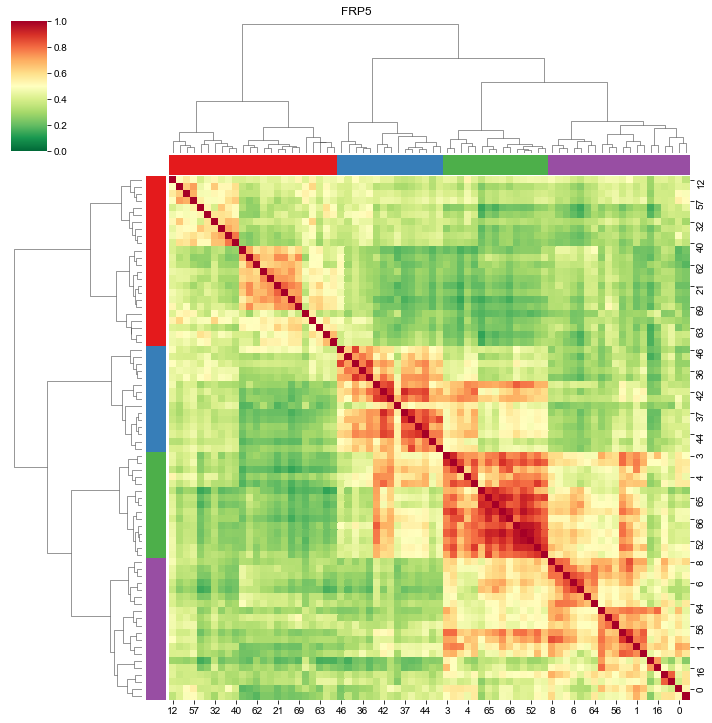

MOs2/3 (218, 218)
MOs2/3 2 0.2619818502027583


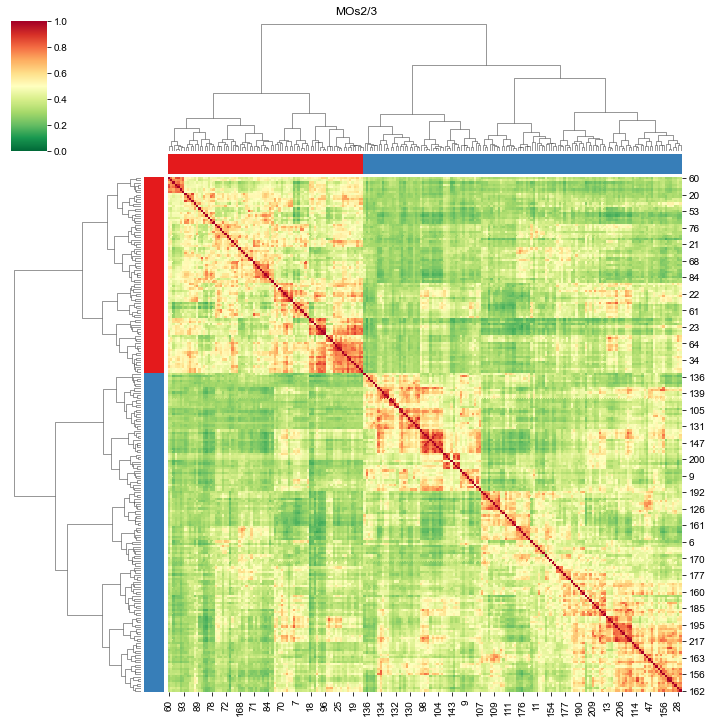

MOs5 (359, 359)
MOs5 2 0.36150916171215225


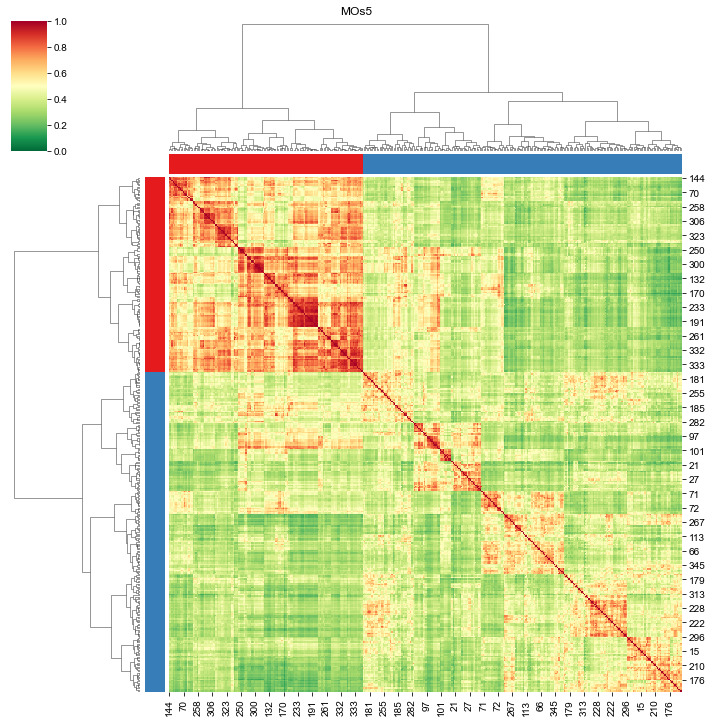

MOs6a (116, 116)
MOs6a 2 0.35075420950421266


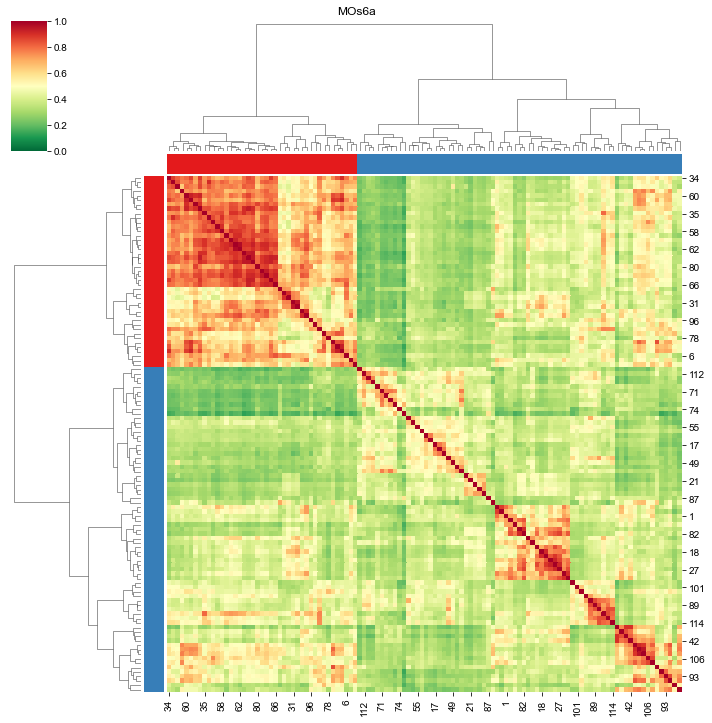

SSp5 (165, 165)
SSp5 2 0.22209692068578135


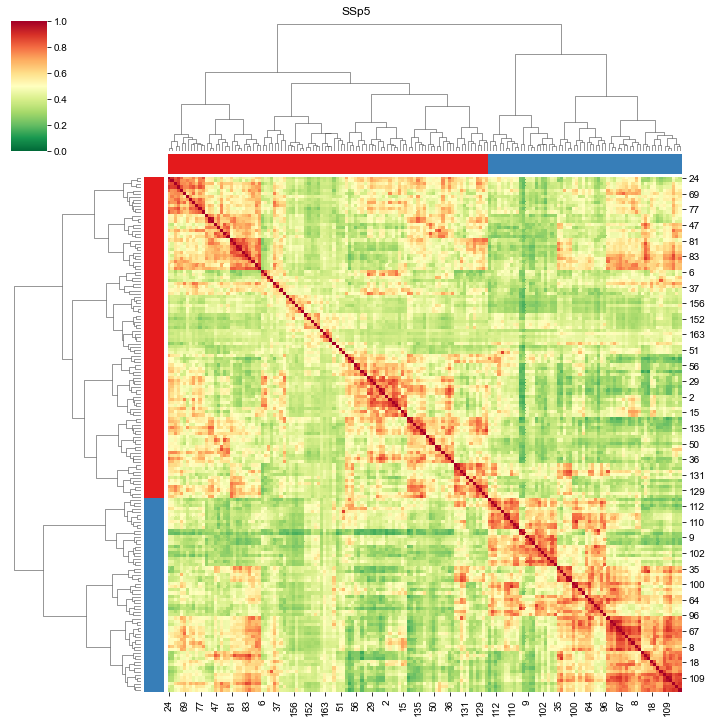

ACAd2/3 (150, 150)
ACAd2/3 2 0.2753424703336682


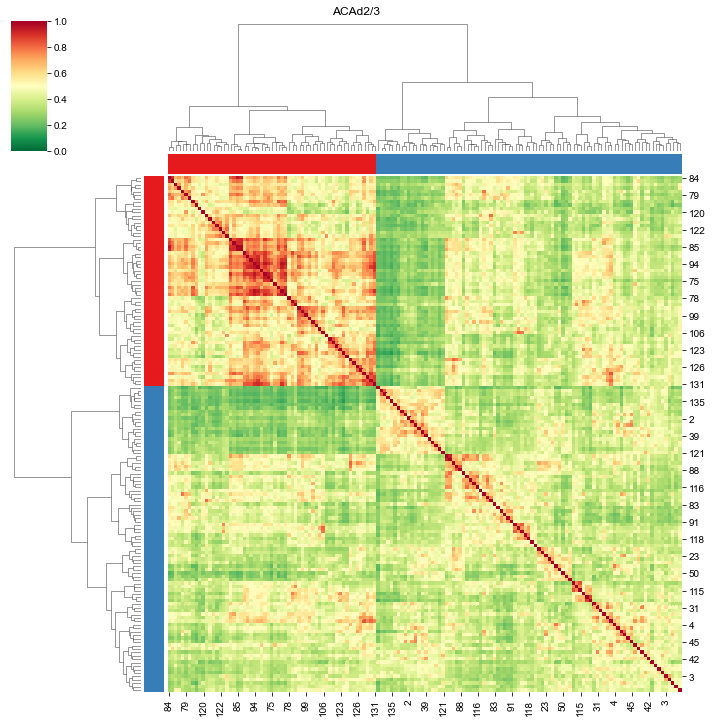

ACAd5 (330, 330)
ACAd5 4 0.31315903305654047


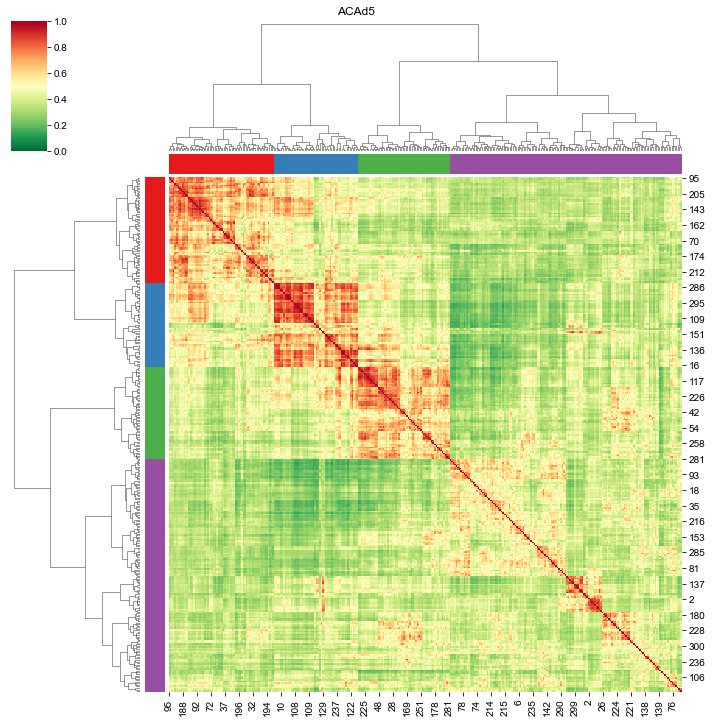

ACAd6a (96, 96)
ACAd6a 2 0.393055892977299


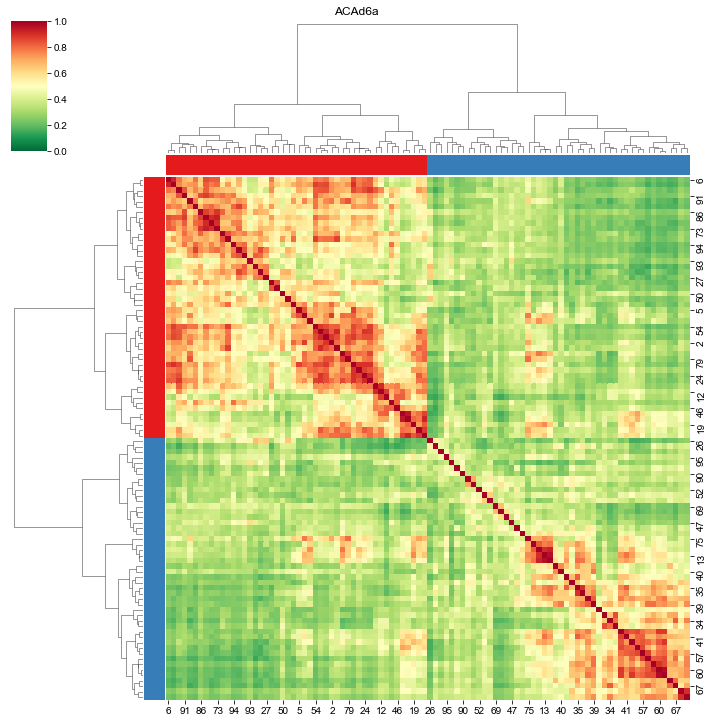

ACAv2/3 (106, 106)
ACAv2/3 5 0.21856076301643365


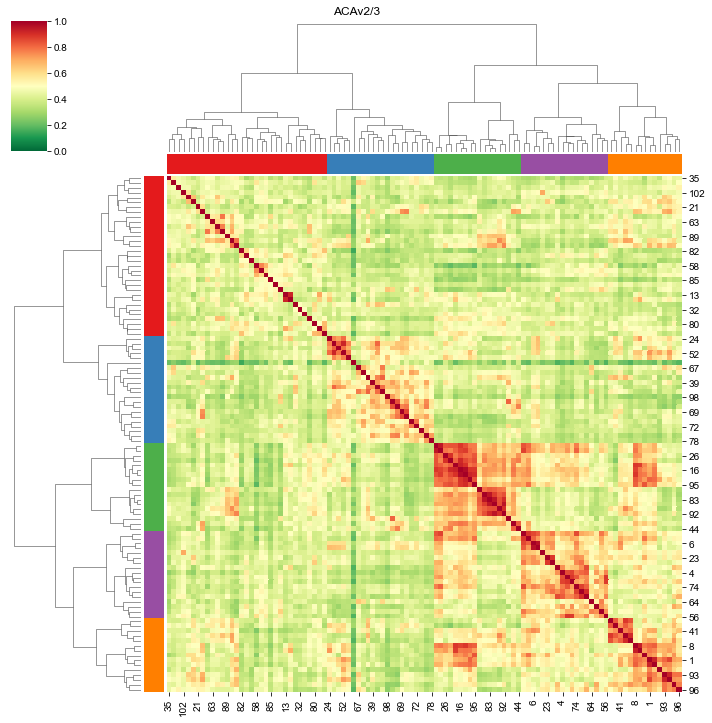

ACAv5 (396, 396)
ACAv5 2 0.3601691284581887


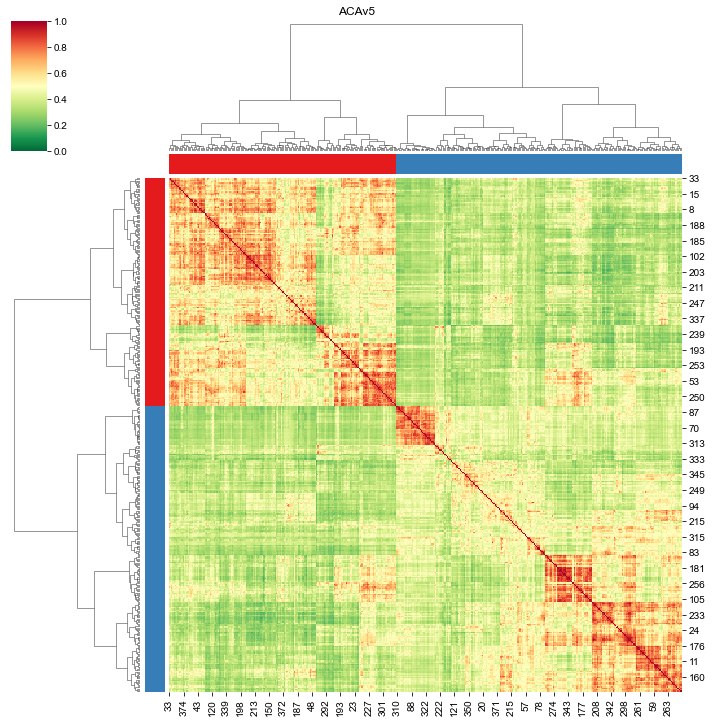

PL2/3 (188, 188)
PL2/3 2 0.3415747379634577


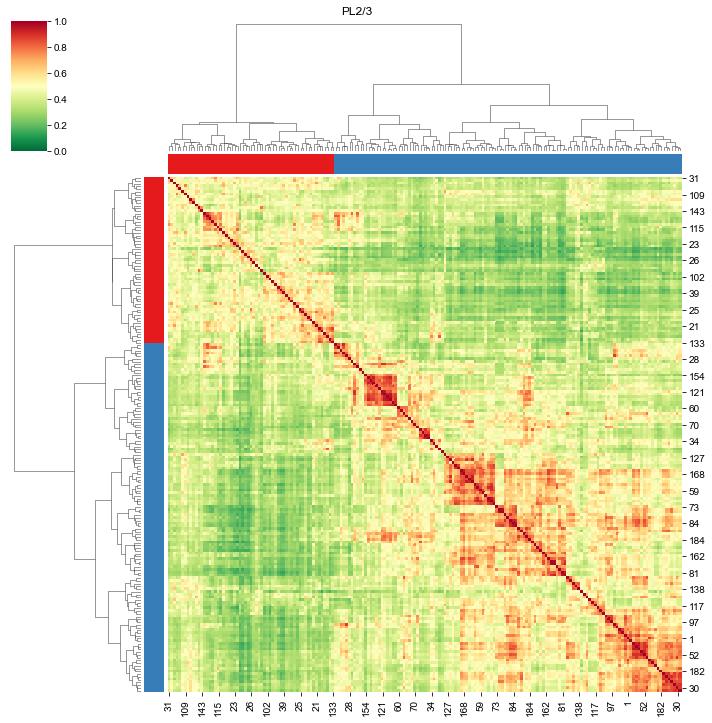

PL5 (795, 795)
PL5 2 0.4394844008904539


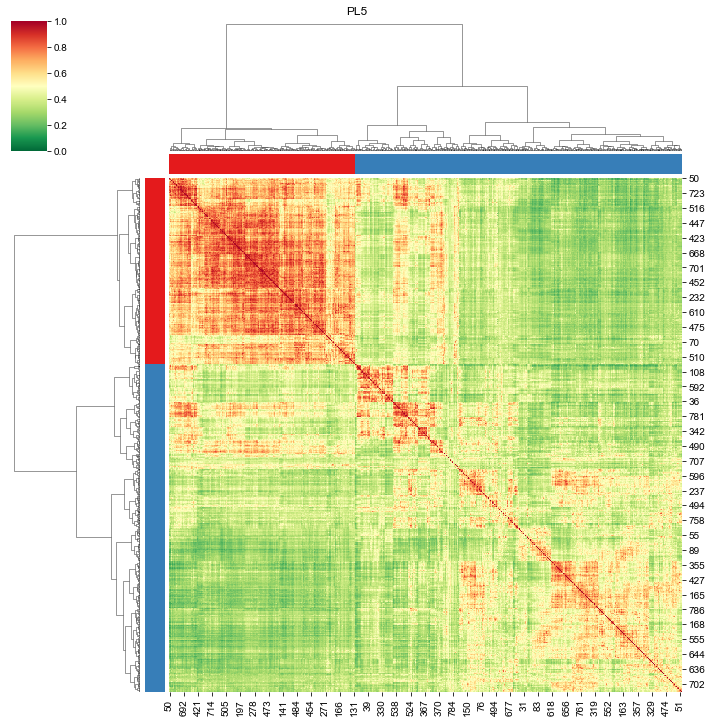

PL6a (99, 99)
PL6a 2 0.3584187188970009


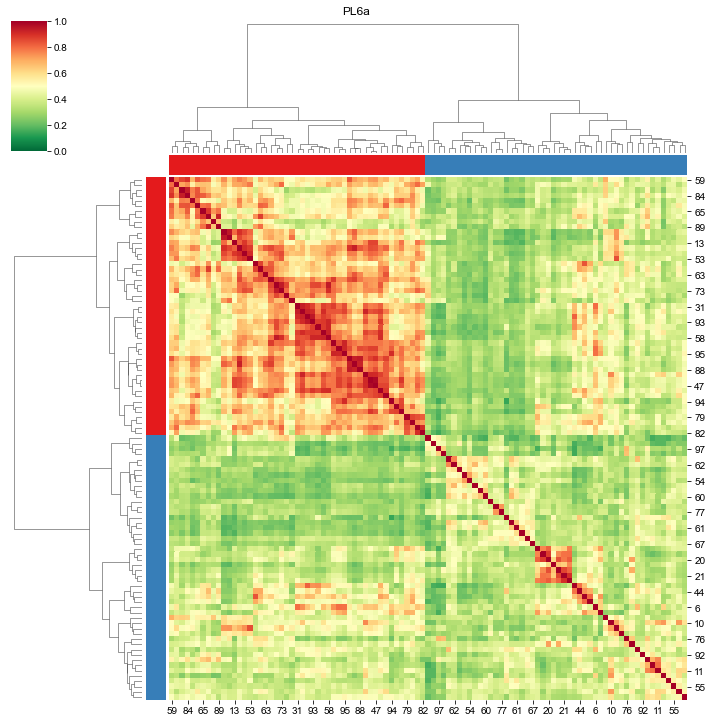

ILA5 (115, 115)
ILA5 3 0.41879514116200217


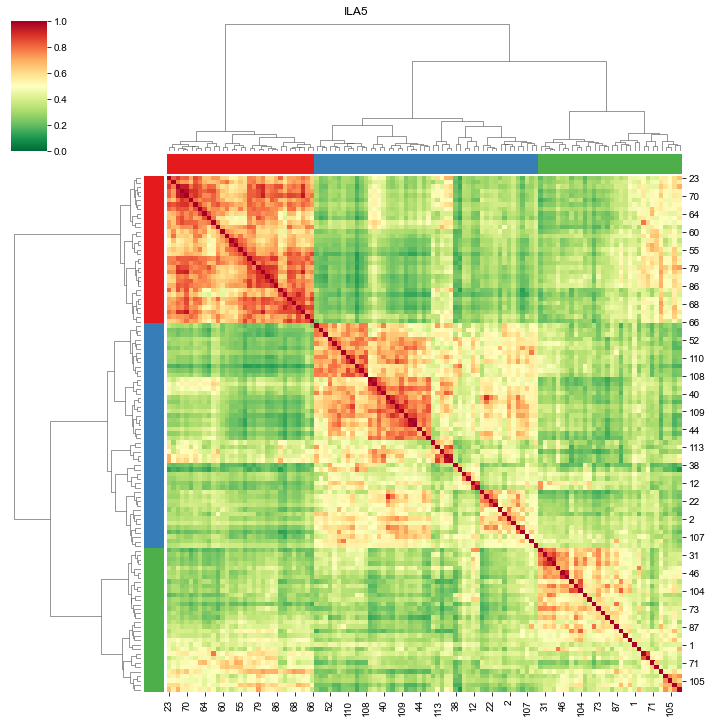

ORBl2/3 (145, 145)
ORBl2/3 2 0.2311420795646284


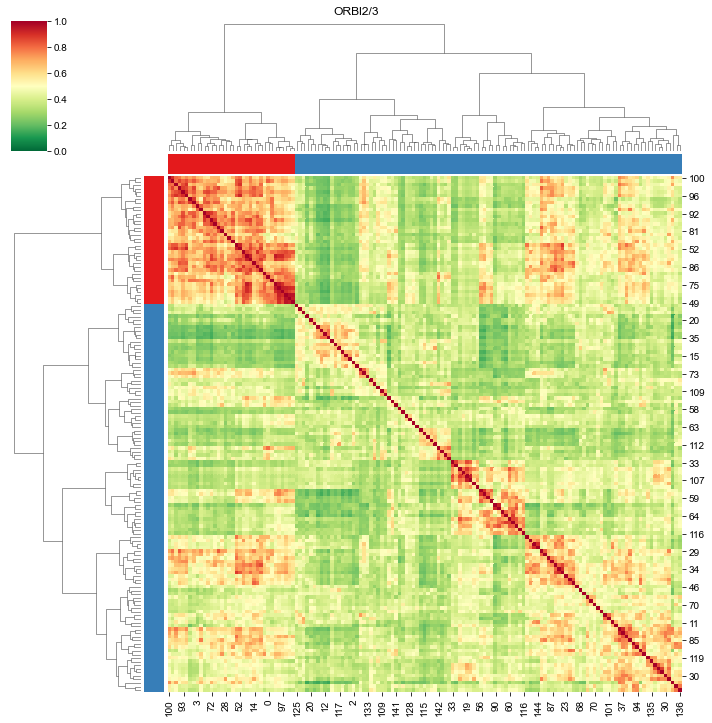

ORBl5 (243, 243)
ORBl5 3 0.40099355362447264


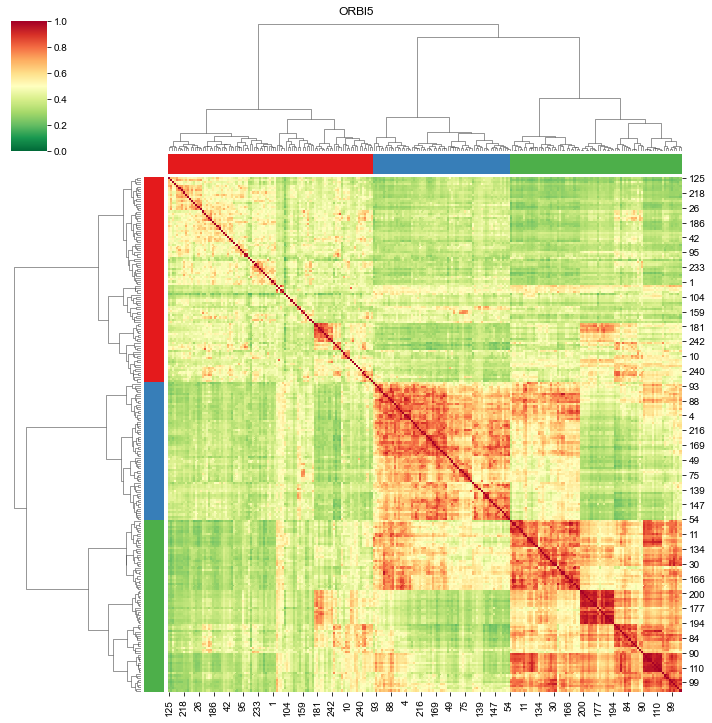

ORBm2/3 (103, 103)
ORBm2/3 3 0.31194256064074694


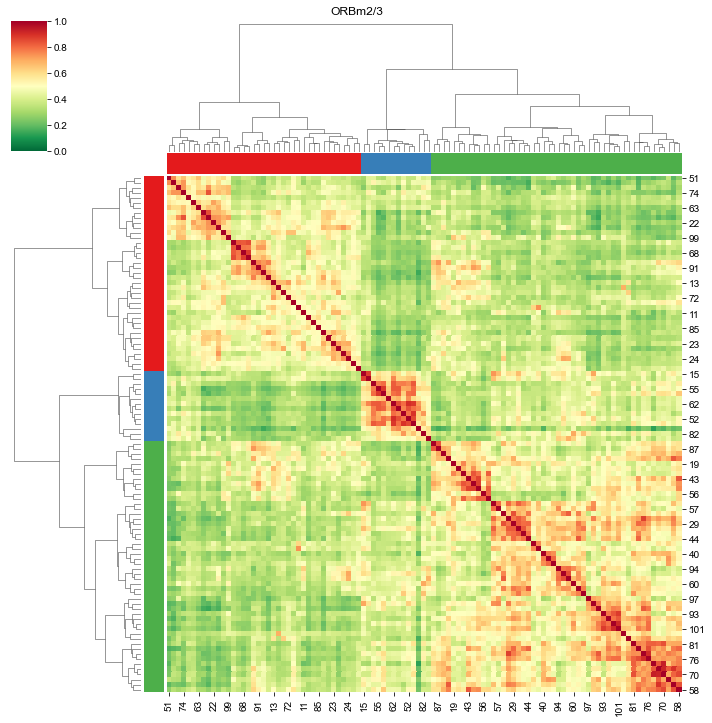

ORBm5 (214, 214)
ORBm5 4 0.35703537848990624


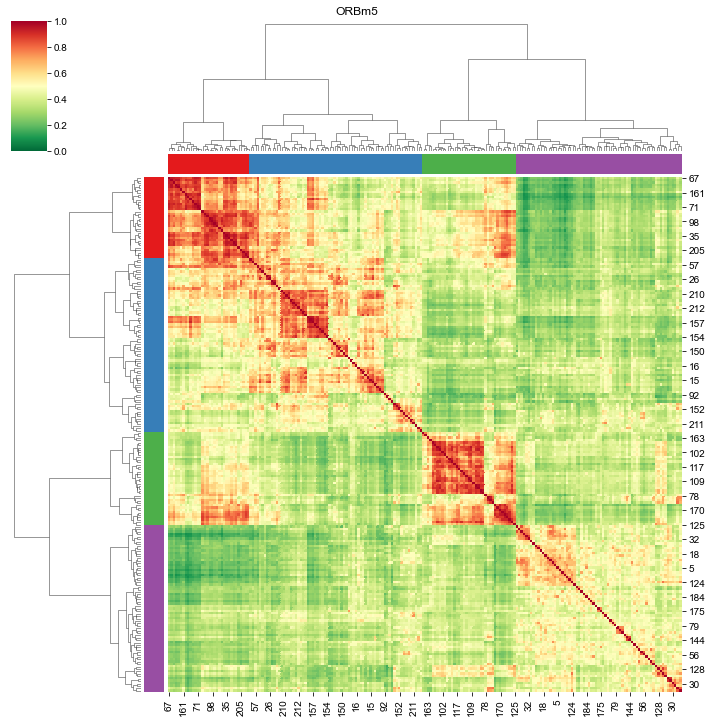

ORBvl1 (94, 94)
ORBvl1 2 0.17341734231102196


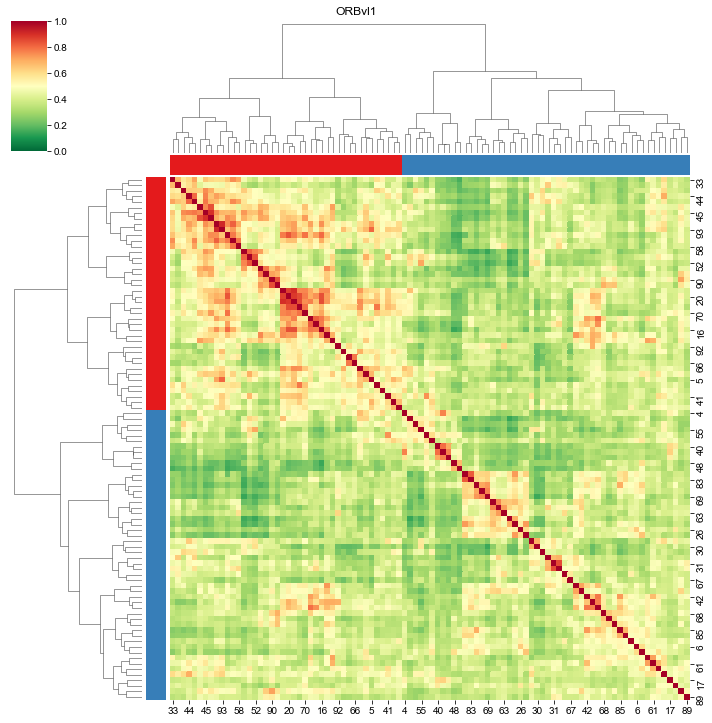

ORBvl2/3 (214, 214)
ORBvl2/3 2 0.3249820351554809


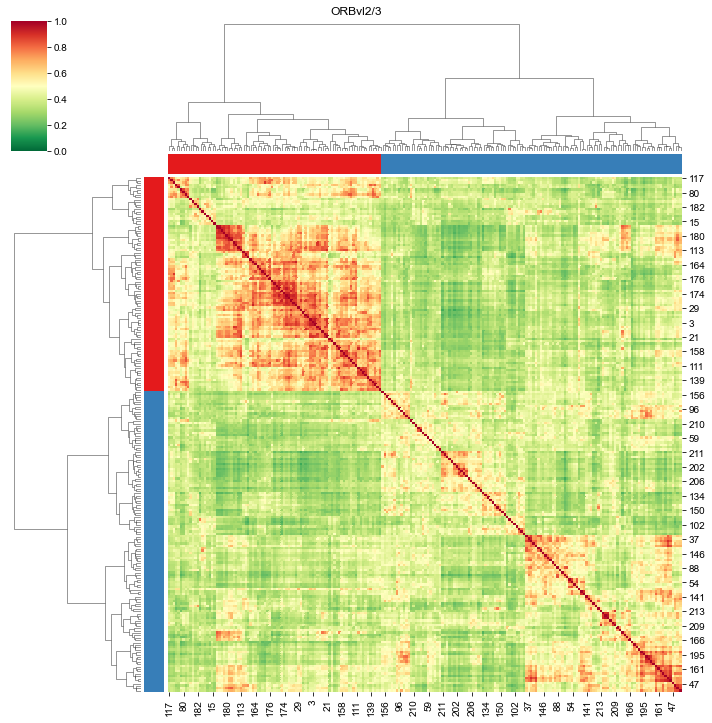

ORBvl5 (306, 306)
ORBvl5 4 0.2987931782479202


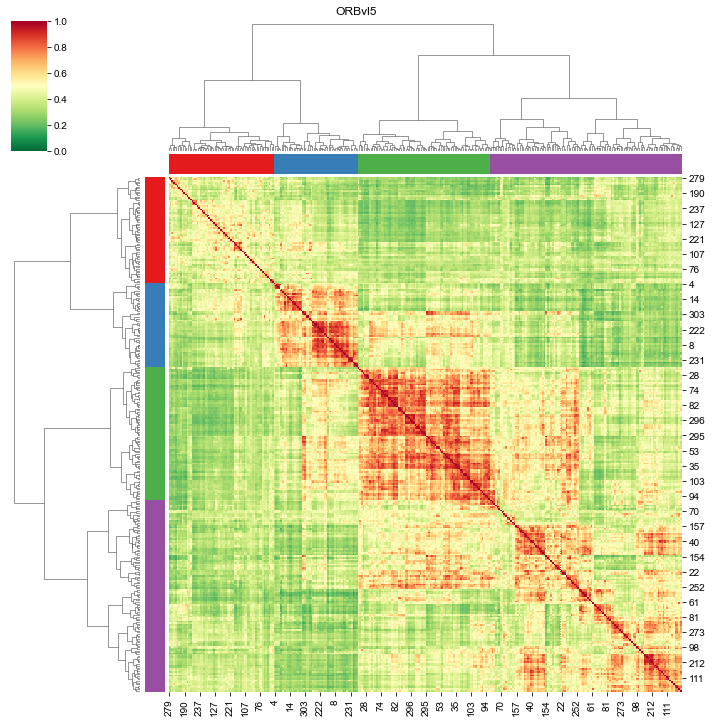

ORBvl6a (74, 74)
ORBvl6a 2 0.38539936825403726


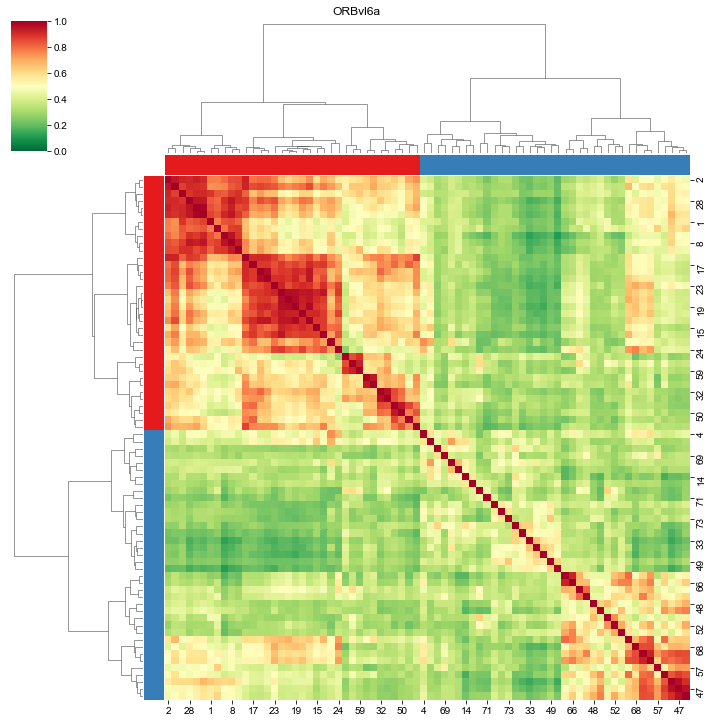

AId2/3 (298, 298)
AId2/3 2 0.27925039639120053


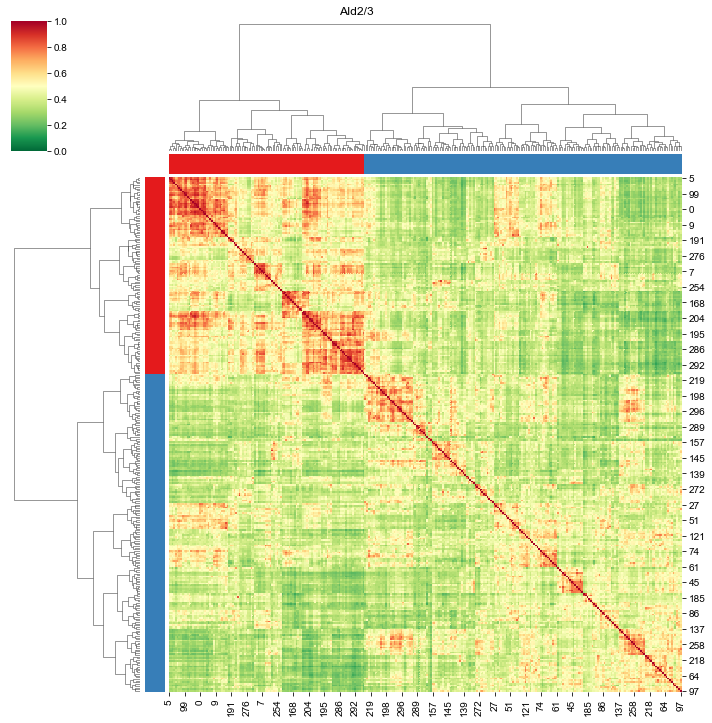

AId5 (447, 447)
AId5 2 0.4040945130054281


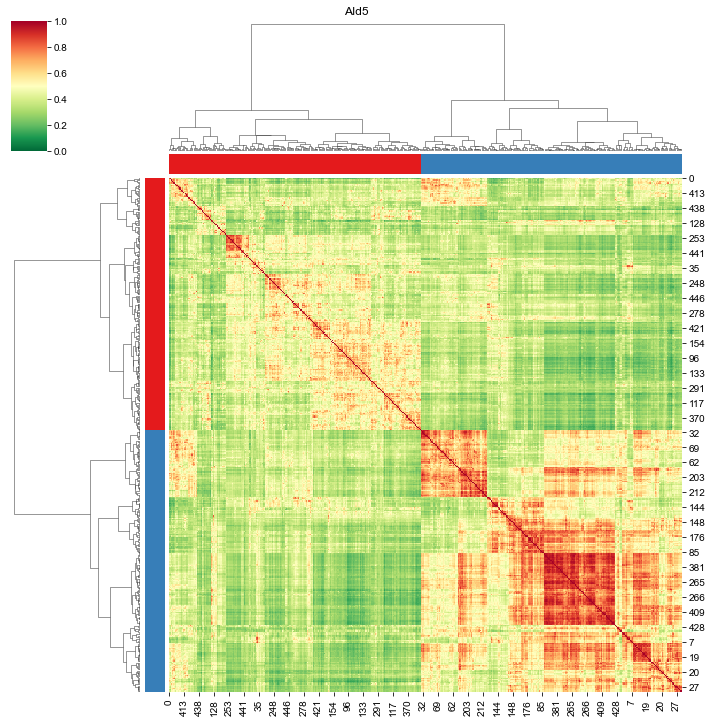

AIv2/3 (94, 94)
AIv2/3 2 0.3583870284309001


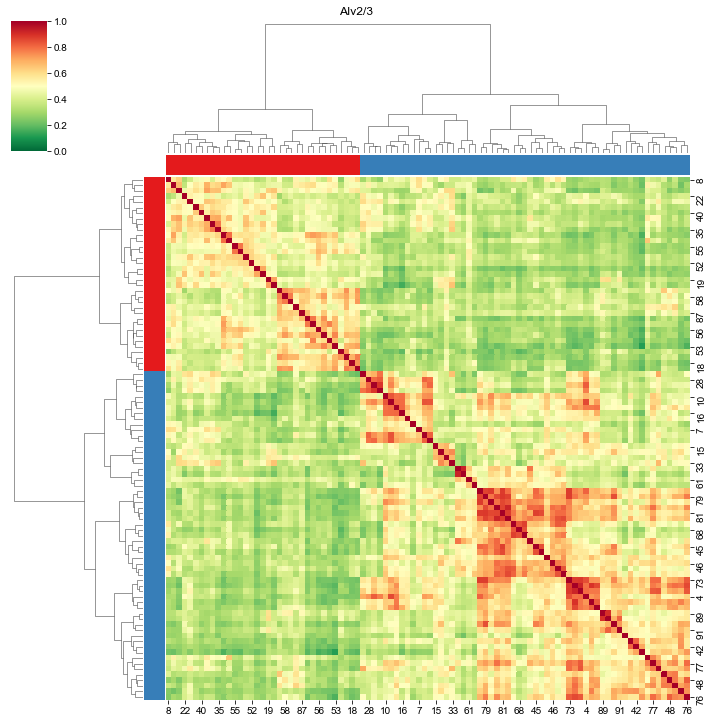

AIv5 (111, 111)
AIv5 3 0.3773176484754983


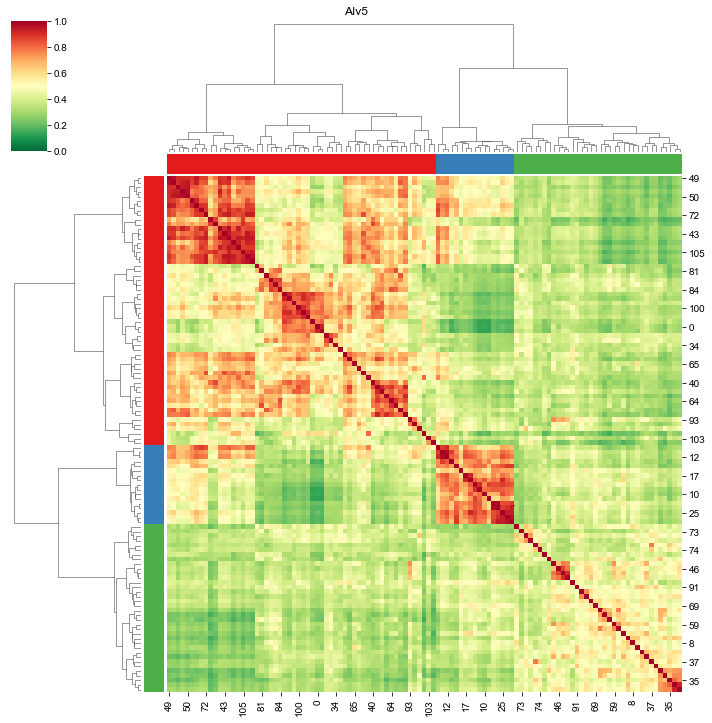

SUB (74, 74)
SUB 6 0.2128721252024708


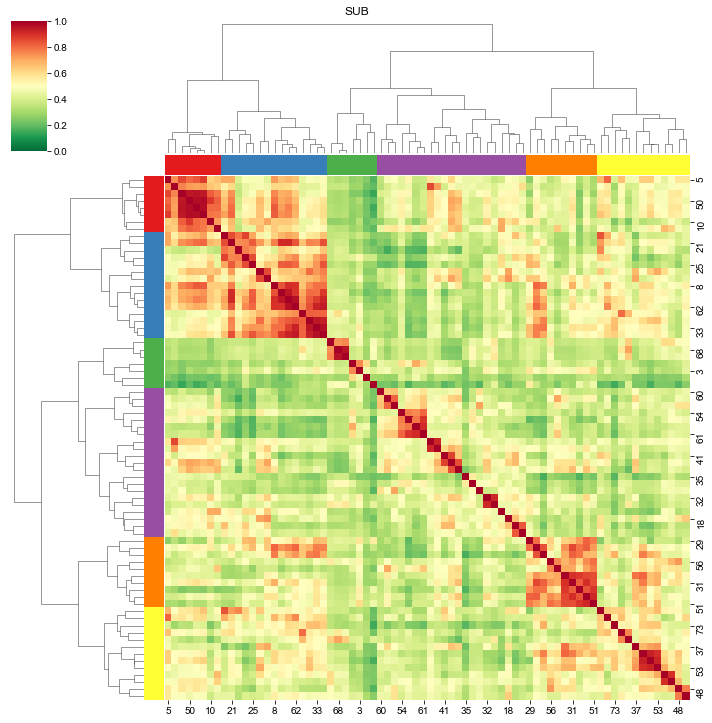

CP (290, 290)
CP 2 0.2985594589535742


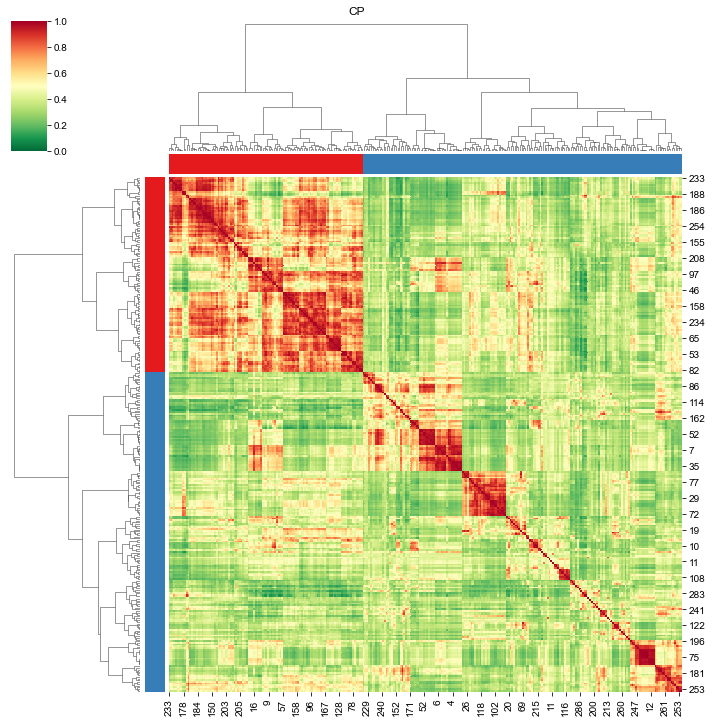

VPL (91, 91)
VPL 2 0.22727756431957255


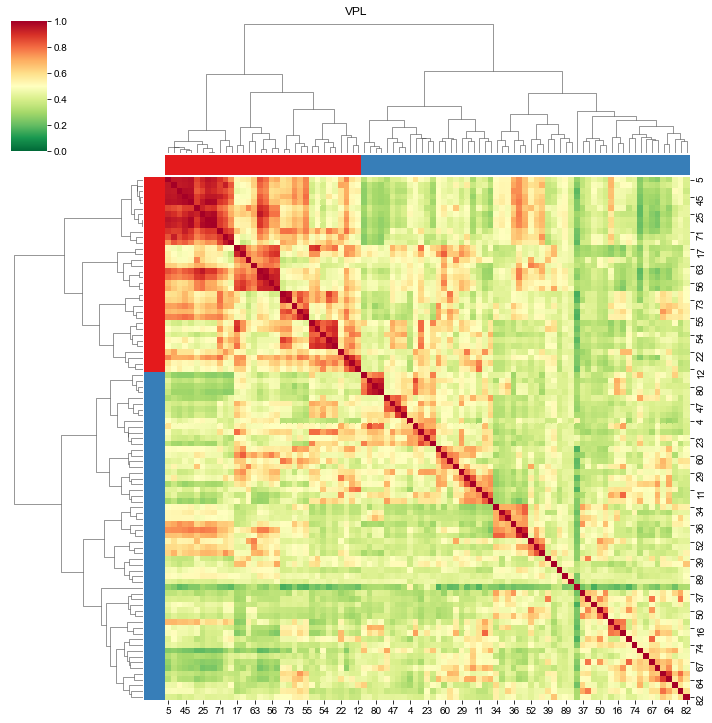

VPM (406, 406)
VPM 2 0.3278801844870145


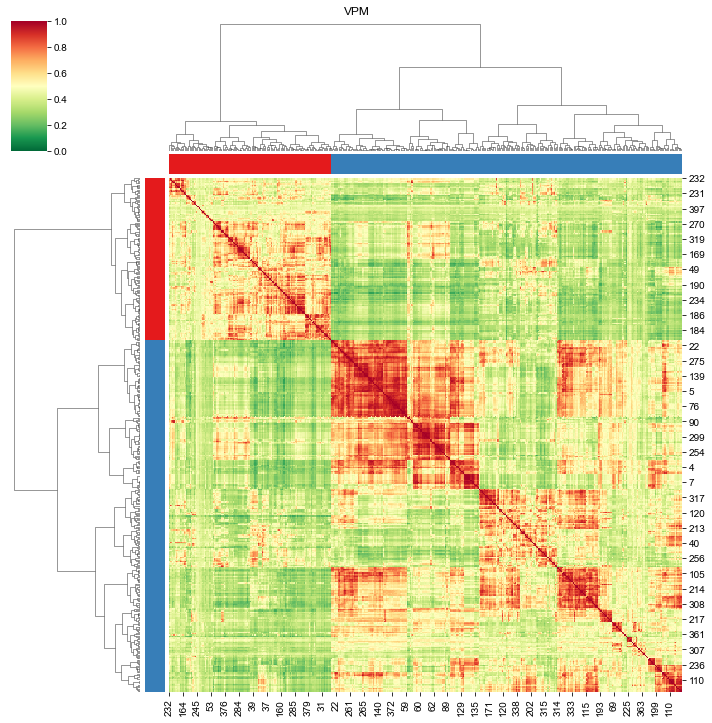

LGd (78, 78)
LGd 2 0.20838546241338518


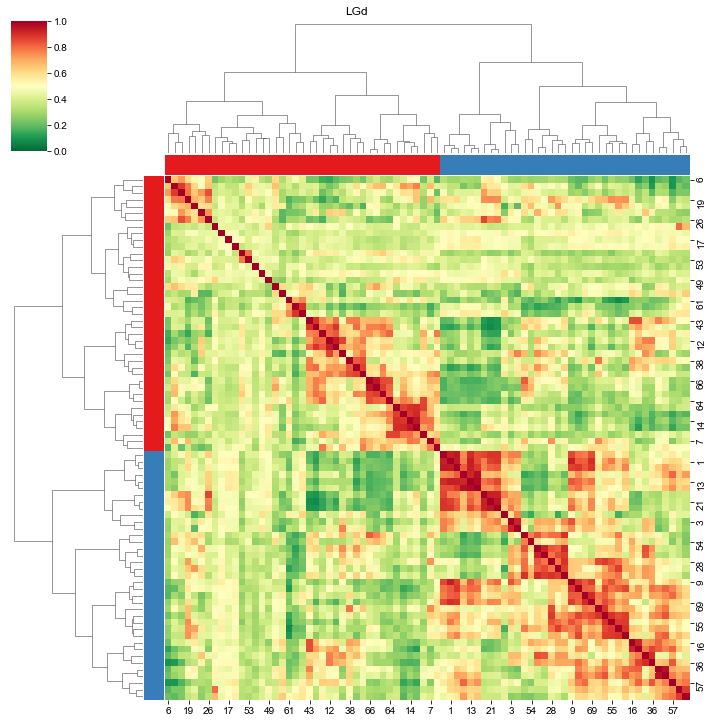

In [41]:
%matplotlib inline
indice=[]
celltypes=[]
clusterids=[]
for i in range(0,len(ctlist)):
    ct=ctlist[i]
    tmpdf = df_ct[df_ct['Detail CellType']==ct]
    # tmpdf = tmpdf.sort_values(by='detail ctype')
    celllist = tmpdf.index

    df_conn = df_overlap.loc[celllist,df_overlap.columns[:-1]]
    conn_stand_value = (df_conn.values - df_conn.values.mean(axis=0)) / (df_conn.values.std(axis=0)+ eps)
    # print(conn_stand_value.shape)
    # PCA
    pca = PCA(0.99)
    conn_stand_value = pca.fit_transform(conn_stand_value)
    # print(conn_stand_value.shape)
    
    conn_sim_mat = generate_similarity_matrix(conn_stand_value)
    conn_sim_mat = (conn_sim_mat+1)/2.
    df_conn_sim_mat = pd.DataFrame(conn_sim_mat,index=df_conn.index,columns=df_conn.index)
    
    df_somaloc = df_sl.loc[celllist]
    # dist_mat = cdist(df_somaloc.values,df_somaloc.values,metric='euclidean')
    # dist_mat = dist_mat/np.max(dist_mat)
    # dist_mat_exp = np.exp(-dist_mat**2)
    
    dist_mat = anatomy_cov_mah_distance(df_somaloc.values, ct)
    dist_mat = dist_mat/np.max(dist_mat)
    dist_mat_exp = np.exp(-dist_mat**2)
    
    aug_mat = conn_sim_mat*dist_mat_exp
    print(ct,aug_mat.shape,)
    pd.DataFrame(aug_mat,index=df_conn.index,columns=df_conn.index).to_csv(rf'./fig5/{ct.replace("2/3","23")}.csv')
    
    linkage = hc.linkage(aug_mat, method='ward',metric='euclidean')
    t,_ = find_best_t(aug_mat, linkage)
    result = hc.fcluster(linkage,t=t,criterion='maxclust')
    print(ct,t, _)
    lut = dict(zip(np.unique(result), sns.color_palette('Set1',t)))
    row_colors = list(map(lambda x:lut.get(x), result))
    
    
    g_cm=sns.clustermap(aug_mat, cmap='RdYlGn_r',method='ward',vmax=1,vmin=0,row_linkage=linkage,col_linkage=linkage,row_colors=row_colors,col_colors=row_colors)
    # g_cm.ax_heatmap.set_aspect('equal','datalim')
    plt.suptitle(ct,y=1)
    # plt.savefig(f'./fig5/flipped/Euclidean/clustermap/{ct.replace("2/3","23")}.png', dpi=250, bbox_inches='tight',facecolor='w')
    # plt.savefig(f'./fig5/flipped/Mahalanobis/clustermap/{ct.replace("2/3","23")}.png', dpi=250, bbox_inches='tight',facecolor='w')
    # plt.savefig(f'./fig5/flipped/Mahalanobis_min3/clustermap/{ct.replace("2/3","23")}.png', dpi=250, bbox_inches='tight',facecolor='w')
    plt.show()
    # plt.clf()
    # plt.close()
    
    cluster_celllist=np.array(celllist)[np.array(g_cm.dendrogram_col.reordered_ind)]

    # save cluster results.
    indice.extend(celllist.tolist())
    clusterids.extend(result.tolist())
    celltypes.extend([ct]*len(celllist))


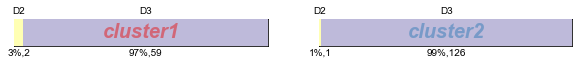

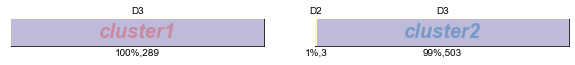

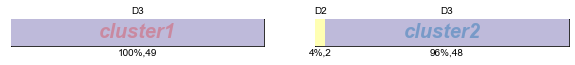

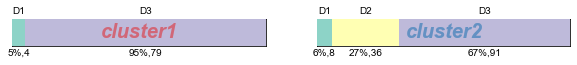

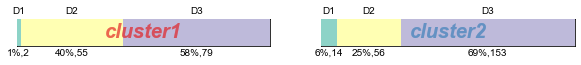

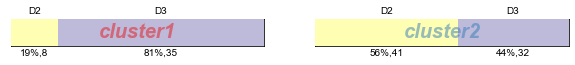

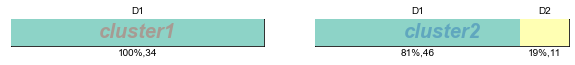

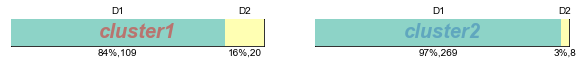

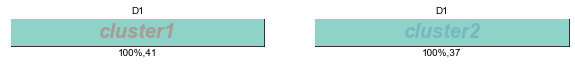

In [42]:
'''plot distribution of different datasets in clustering results'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_cluster_result = pd.read_csv(os.path.join(material_path,'cell_type/c_type','ctype_mirrored.csv'),index_col=0)
df_cluster_result[['celltype', 'cluster']] = df_cluster_result['detail ctype'].str.split('_', expand=True)

for ct in ['PL2/3','PL5','PL6a','MOs2/3','MOs5','MOs6a','VPL','VPM','LGd']:
    tmpdf = df_cluster_result[df_cluster_result['celltype']==ct]
    fig,axs = plt.subplots(1,len(np.unique(tmpdf['cluster'])),tight_layout=False,figsize=(10,0.5))
    for c_i,cluster in enumerate(np.unique(tmpdf['cluster'])):
        sumcount = [0,0,0]  # 3 datasets: AIBS-SEU, MouseLight, ION
        for ind in tmpdf[tmpdf['cluster']==cluster].index:
            if ind.find('reg')!=-1:
                sumcount[2]+=1
            elif ind.find('AA')!=-1:
                sumcount[1]+=1
            else:
                sumcount[0]+=1
        ax = axs[c_i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0,1)
        ax.set_ylim(-0.5,0.5)
        for ds_i in range(len(sumcount)):
            if sumcount[ds_i]==0: continue
            tmpcount = np.sum(sumcount[:ds_i+1])
            ax.barh(0,tmpcount/np.sum(sumcount),zorder=10-ds_i,color=sns.color_palette('Set3')[ds_i],height=1)
            ax.text(s=f'D{ds_i+1}',
                    x=(np.sum(([0]+(sumcount/np.sum(sumcount)).tolist())[:ds_i+1])+np.sum((sumcount/np.sum(sumcount))[:ds_i+1]))/2, 
                    y=0.5*1.2, va='bottom',ha='center')
            perc = round(100*sumcount[ds_i]/np.sum(sumcount))
            perc_count_text = f'{perc:0d}%,{sumcount[ds_i]}' if perc!=0 else f'{round(100*sumcount[ds_i]/np.sum(sumcount),1):.1f}%,{sumcount[ds_i]}'
            ax.text(s=perc_count_text,
                    x=(np.sum(([0]+(sumcount/np.sum(sumcount)).tolist())[:ds_i+1])+np.sum((sumcount/np.sum(sumcount))[:ds_i+1]))/2, 
                    y=-0.5*1.2-0.3 if abs(sumcount[ds_i]-([0]+sumcount)[ds_i])/np.sum(sumcount)<0.2 \
                    and ([0]+sumcount)[ds_i]!=0 \
                    and (sumcount[ds_i]/np.sum(sumcount)<0.2 and ([0]+sumcount)[ds_i]/np.sum(sumcount)<0.2) else -0.5*1.2, va='top',ha='center')
            ax.text(0.5,0,f'cluster{cluster}',va='center',ha='center',alpha=0.3,color=sns.color_palette('Set1')[c_i],
                    fontsize=20,zorder=20,fontstyle='italic',fontweight='bold')
            
    fig.savefig(f'./fig5/{ct.replace("2/3","23")}.svg', dpi=300, bbox_inches='tight',transparent=True)
    plt.show(fig)